In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import nltk
from nltk.corpus import stopwords
import torch
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForTokenClassification, TrainingArguments, Trainer
from accelerate import Accelerator
import shutil
from IPython.display import FileLink

c:\Users\Vijay\Downloads\sudar\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Dataset loading

In [2]:
# Load dataset and limit to 5000 rows
dataset = load_dataset("conll2003", trust_remote_code=True)
small_train_dataset = dataset["train"].select(range(5000))

c:\Users\Vijay\Downloads\sudar\venv\Lib\site-packages\huggingface_hub\file_download.py:142: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Vijay\.cache\huggingface\hub\datasets--conll2003. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Generating test split: 100%|██████████| 3453/3453 [00:00<00:00, 11466.28 examples/s]


## Data Exploration

In [3]:
# Convert to DataFrame
df = pd.DataFrame({
    "tokens": small_train_dataset["tokens"],
    "ner_tags": small_train_dataset["ner_tags"],
    "pos_tags": small_train_dataset["pos_tags"],
    "chunk_tags": small_train_dataset["chunk_tags"]
})


In [4]:
df.head()

,tokens,ner_tags,pos_tags,chunk_tags
0,"[EU, rejects, German, call, to, boycott, Briti...","[3, 0, 7, 0, 0, 0, 7, 0, 0]","[22, 42, 16, 21, 35, 37, 16, 21, 7]","[11, 21, 11, 12, 21, 22, 11, 12, 0]"
1,"[Peter, Blackburn]","[1, 2]","[22, 22]","[11, 12]"
2,"[BRUSSELS, 1996-08-22]","[5, 0]","[22, 11]","[11, 12]"
3,"[The, European, Commission, said, on, Thursday...","[0, 3, 4, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, ...","[12, 22, 22, 38, 15, 22, 28, 38, 15, 16, 21, 3...","[11, 12, 12, 21, 13, 11, 11, 21, 13, 11, 12, 1..."
4,"[Germany, 's, representative, to, the, Europea...","[5, 0, 0, 0, 0, 3, 4, 0, 0, 0, 1, 2, 0, 0, 0, ...","[22, 27, 21, 35, 12, 22, 22, 27, 16, 21, 22, 2...","[11, 11, 12, 13, 11, 12, 12, 11, 12, 12, 12, 1..."


In [5]:
df.shape

(5000, 4)

In [6]:
df.dtypes

tokens        object
ner_tags      object
pos_tags      object
chunk_tags    object
dtype: object

In [7]:
print(df.describe(include='all'))

                      tokens ner_tags  pos_tags chunk_tags
count                   5000     5000      5000       5000
unique                  4605     2164      3240       2802
top     [LONDON, 1996-08-23]   [5, 0]  [22, 11]   [11, 12]
freq                      14      233       170        318


In [8]:
print(df.isnull().sum())

tokens        0
ner_tags      0
pos_tags      0
chunk_tags    0
dtype: int64


In [9]:
print(df["ner_tags"].explode().value_counts())

ner_tags
0    55196
5     2768
1     2584
3     2058
2     1875
7     1236
4     1105
8      455
6      357
Name: count, dtype: int64


In [10]:
sentence_lengths = df["tokens"].apply(len)
print(sentence_lengths.describe())

count    5000.000000
mean       13.526800
std        11.246412
min         1.000000
25%         5.000000
50%         9.000000
75%        20.000000
max        60.000000
Name: tokens, dtype: float64


In [11]:
for i in range(5):
    print(f"Sentence {i+1}: {' '.join(df['tokens'][i])}")
    print(f"NER Tags   : {df['ner_tags'][i]}")
    print("-" * 50)


Sentence 1: EU rejects German call to boycott British lamb .
NER Tags   : [3, 0, 7, 0, 0, 0, 7, 0, 0]
--------------------------------------------------
Sentence 2: Peter Blackburn
NER Tags   : [1, 2]
--------------------------------------------------
Sentence 3: BRUSSELS 1996-08-22
NER Tags   : [5, 0]
--------------------------------------------------
Sentence 4: The European Commission said on Thursday it disagreed with German advice to consumers to shun British lamb until scientists determine whether mad cow disease can be transmitted to sheep .
NER Tags   : [0, 3, 4, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
--------------------------------------------------
Sentence 5: Germany 's representative to the European Union 's veterinary committee Werner Zwingmann said on Wednesday consumers should buy sheepmeat from countries other than Britain until the scientific advice was clearer .
NER Tags   : [5, 0, 0, 0, 0, 3, 4, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0,

## Data Visualization

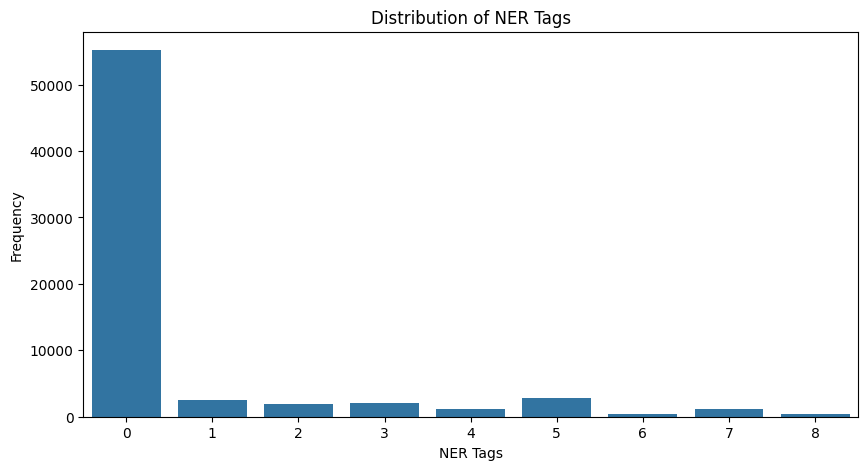

In [12]:
# NER Tag distribution
ner_tag_counts = Counter(tag for tags in df["ner_tags"] for tag in tags)
plt.figure(figsize=(10, 5))
sns.barplot(x=list(ner_tag_counts.keys()), y=list(ner_tag_counts.values()))
plt.xlabel("NER Tags")
plt.ylabel("Frequency")
plt.title("Distribution of NER Tags")
plt.show()

## Tokenization & Preprocessing

In [13]:
# Tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

c:\Users\Vijay\Downloads\sudar\venv\Lib\site-packages\huggingface_hub\file_download.py:142: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Vijay\.cache\huggingface\hub\models--bert-base-cased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [14]:
# Label mapping
label_list = dataset["train"].features["ner_tags"].feature.names
label2id = {label: i for i, label in enumerate(label_list)}
id2label = {i: label for label, i in label2id.items()}

In [15]:
# Tokenization function
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"], 
        truncation=True, 
        padding="max_length",  # Ensures all sequences are the same length
        max_length=128,  # Adjust max length based on your data
        is_split_into_words=True
    )

    labels = []
    for i, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        label_ids = [-100 if word_id is None else label[word_id] for word_id in word_ids]
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [16]:
# Apply tokenization with fix
tokenized_dataset = dataset.map(tokenize_and_align_labels, batched=True).shuffle(seed=42)

Map:   0%|          | 0/14041 [00:00<?, ? examples/s]

Map: 100%|██████████| 3453/3453 [00:00<00:00, 7441.75 examples/s]


In [17]:
# Splitting dataset
train_dataset = tokenized_dataset["train"]
val_dataset = tokenized_dataset["validation"]

# Select first 5000 rows for faster training
train_tokens = train_dataset.select(range(min(5000, len(train_dataset))))
val_tokens = val_dataset.select(range(min(1000, len(val_dataset))))  # Use a smaller validation set


In [18]:
# Load model
model = AutoModelForTokenClassification.from_pretrained(
    "bert-base-cased", num_labels=len(label_list), id2label=id2label, label2id=label2id
)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
# Training arguments with optimizations
training_args = TrainingArguments(
    output_dir="./bert-ner",
    evaluation_strategy="epoch",  
    save_strategy="epoch",
    learning_rate=3e-5,  # Slightly lower LR for better convergence
    per_device_train_batch_size=16,  # Smaller batch size for faster processing
    per_device_eval_batch_size=16,
    num_train_epochs=2,  # Fewer epochs
    weight_decay=0.01,
    fp16=True,  # Mixed precision for speed
    logging_steps=500,  
    gradient_accumulation_steps=1,  
    save_total_limit=1,  # Keep only latest checkpoint
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokens,
    eval_dataset=val_tokens,
    tokenizer=tokenizer
)

# Train model
trainer.train()

# Save trained model
model_save_path = "./bert-ner-trained"
trainer.save_model(model_save_path)

# Zip the model directory for easier download
shutil.make_archive(model_save_path, 'zip', model_save_path)

# Provide a link to download the model
print("Click the link below to download the trained model:")
FileLink(f"{model_save_path}.zip")


c:\Users\Vijay\Downloads\sudar\venv\Lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\Vijay\AppData\Local\Temp\ipykernel_28972\809739899.py:18: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,No log,0.099076
2,0.196900,0.082575


Click the link below to download the trained model:


c:\Users\Vijay\Downloads\sudar\bert-ner-trained.zip